In [ ]:
#!pip install matplotlib --upgrade

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import  seaborn as sns

## Import data

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [3]:
df = pd.read_csv("/content/drive/MyDrive/belajar python/case study/rakamin_home_credit/data/clean/application_train_min.csv",index_col= "sk_id_curr")
df = reduce_mem_usage(df)

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 60.71 MB
Decreased by 78.8%


## EDA

### Missing Values

<Figure size 1440x432 with 0 Axes>

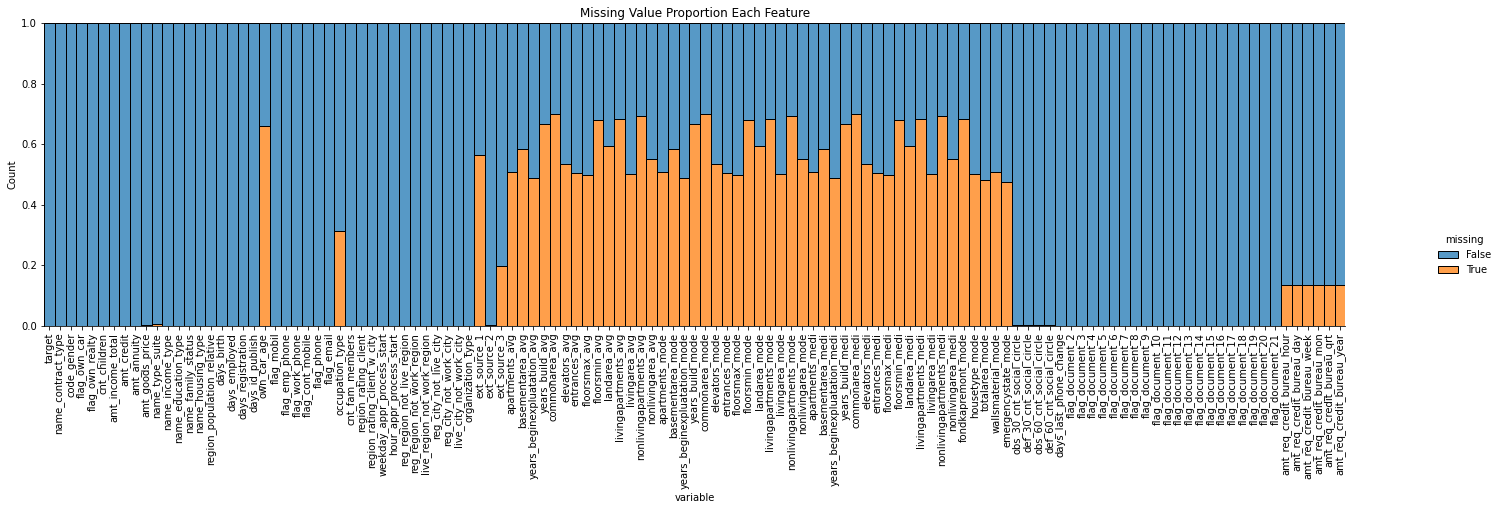

In [ ]:
plt.figure(figsize=(20,6))
sns.displot(
    data=df.isna().melt(value_name="missing"),
    x="variable",
    hue="missing",
    multiple="fill",
    aspect=4
)
plt.xticks(rotation = 90)
plt.title("Missing Value Proportion Each Feature");

it can be seen that many columns have a missing value of more than 50%, this column is a column ending in _avg, _medi, and also _mode. so that the resulting model is not too biased due to missing values, therefore it will be filtered by columns that have a missing value of less than 40%

In [44]:
df_missing = df.isna().mean().to_frame("missing").reset_index()
no_mis_col = df_missing[df_missing.missing <= 0.4]["index"].to_list()
df[no_mis_col].shape

(307511, 72)

sesudah melakukan filter terhadap kolom yang memiliki nilai missing values, didapatkan data baru dengan jumlah kolom sebanyak 72

### Numerical Columns 

In [ ]:
num_col = df[no_mis_col].select_dtypes(include = np.number).columns

In [ ]:
len(num_col)

60

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


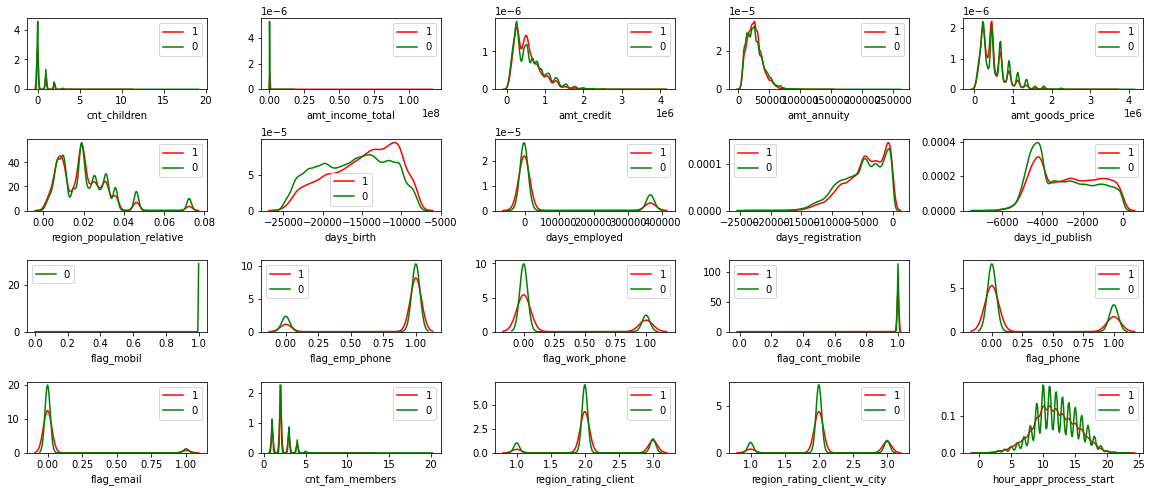

In [ ]:
# Plot KDE Berdasarkan Target
def plot_kde(data,start,end,row_num,col_num,title,target ):
    df_set_pos = data[data[target] == 1].drop(target,axis = 1)
    df_set_neg = data[data[target] == 0].drop(target,axis = 1)
    df_set_pos = df_set_pos.iloc[:,start:end+1]
    df_set_neg = df_set_neg.iloc[:,start:end +1]
    #plot numerical data (Classification Task)
    
    numerical = df_set_pos.select_dtypes(include=np.number).columns
    fig, axes = plt.subplots(row_num,col_num,figsize = (20,8))
    fig.subplots_adjust(hspace=0.7, wspace=0.3)
    fig.suptitle(title,fontsize = 20)
    row = 0
    cols = 0

    for item in numerical:
        if cols > col_num -1:
            cols = 0
            row += 1
        ax1 = sns.kdeplot(x = item,data = df_set_pos,ax = axes[row,cols],color = "red" ,label = "1")
        ax2 = sns.kdeplot(x = item,data = df_set_neg,ax = axes[row,cols],color = "green" ,label = "0")
        ax1.legend()
        ax1.set_ylabel("")
        ax2.set_ylabel("")
        cols += 1

plot_kde(df[num_col],0,19,4,5,'',"target")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


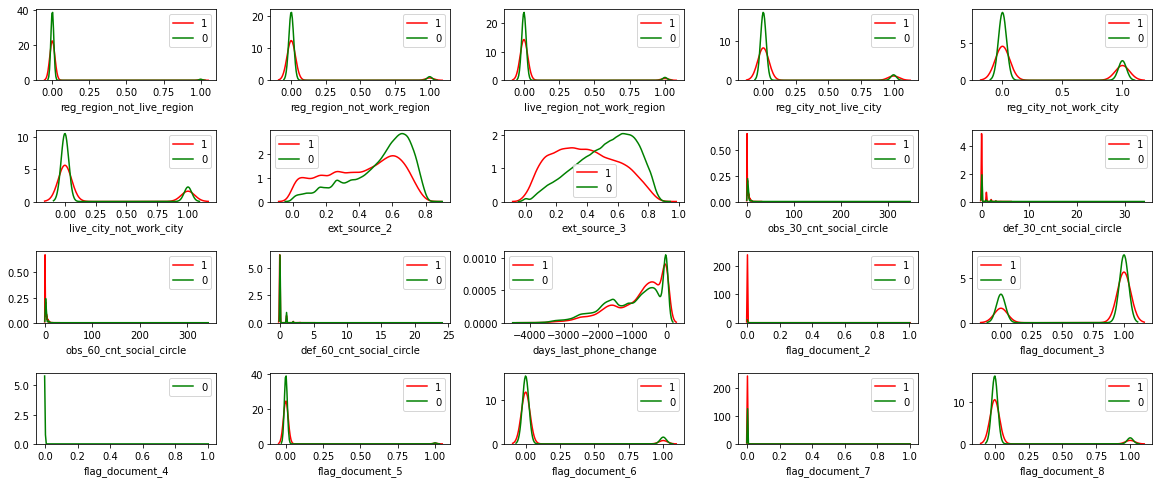

In [ ]:
plot_kde(df[num_col],20,39,4,5,'',"target")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


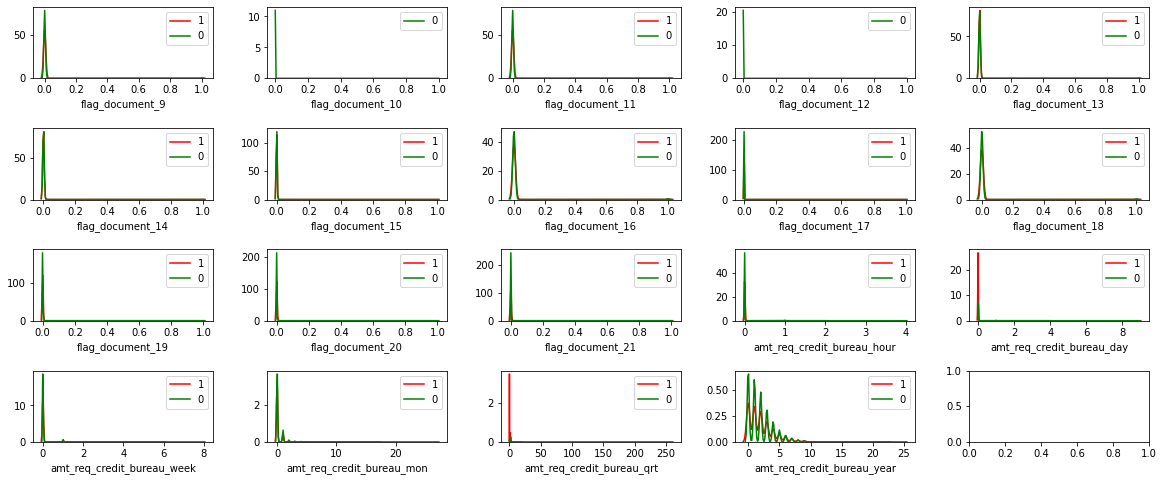

In [ ]:
plot_kde(df[num_col],40,59,4,5,'',"target")

### Categorical Data

In [ ]:
df.select_dtypes(include=["category"]).columns

Index(['name_contract_type', 'code_gender', 'flag_own_car', 'flag_own_realty',
       'name_type_suite', 'name_income_type', 'name_education_type',
       'name_family_status', 'name_housing_type', 'occupation_type',
       'weekday_appr_process_start', 'organization_type', 'fondkapremont_mode',
       'housetype_mode', 'wallsmaterial_mode', 'emergencystate_mode'],
      dtype='object')

In [4]:
cat_df = df.select_dtypes(include=["category"]).nunique().to_frame("n_unique").reset_index()
cat_col_4 = cat_df[cat_df.n_unique <= 4]['index'].values
cat_col_5 = cat_df[(cat_df.n_unique >= 5) & (cat_df.n_unique <= 10)]["index"].values
cat_df

,index,n_unique
0,name_contract_type,2
1,code_gender,3
2,flag_own_car,2
3,flag_own_realty,2
4,name_type_suite,7
5,name_income_type,8
6,name_education_type,5
7,name_family_status,6
8,name_housing_type,6
9,occupation_type,18


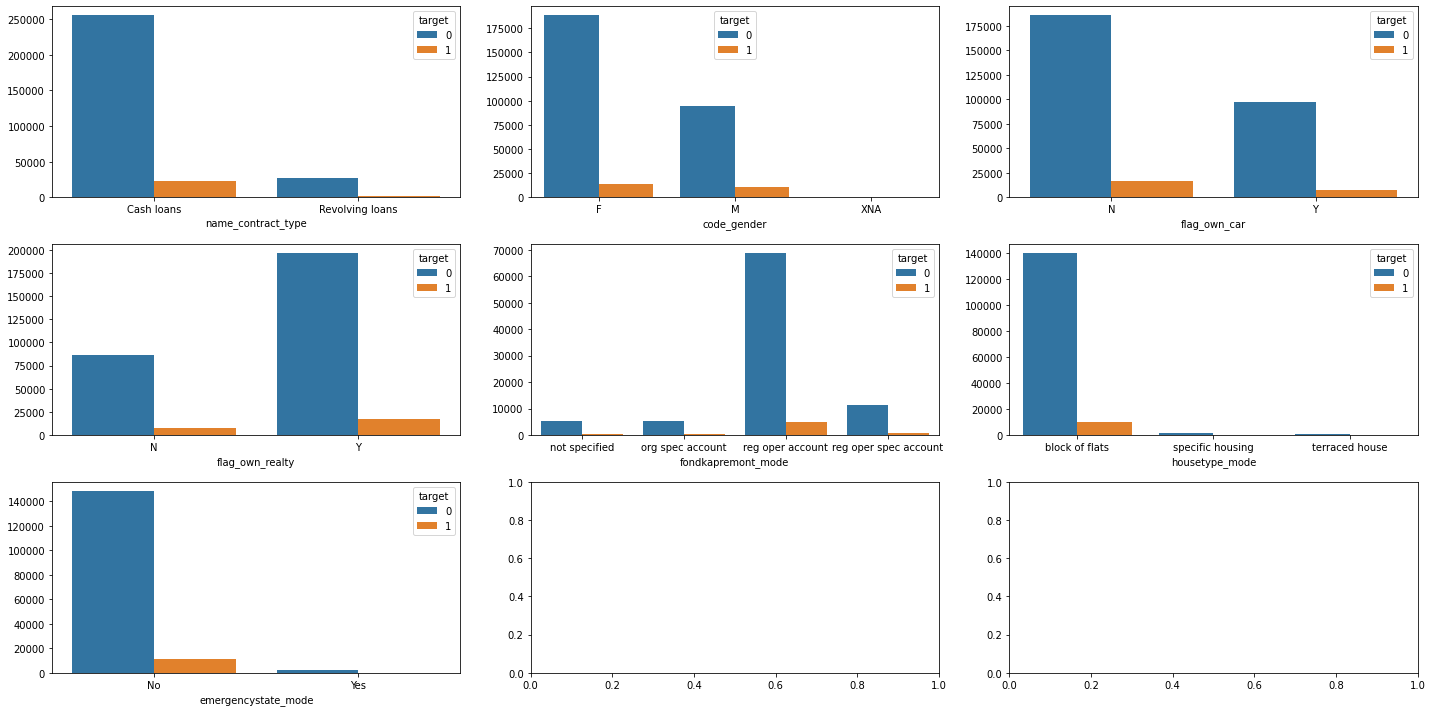

In [ ]:
#plot categorical Data (classification Task)
categorical = cat_col_4

fig, axes = plt.subplots(3, 3, figsize=(20, 10))
row = 0
cols = 0
for item in categorical:
    sns.countplot(x=item, hue="target", data=df, ax=axes[row][cols]).set_ylabel("")
    cols += 1
    if cols == 3:
        cols = 0
        row += 1
fig.tight_layout()

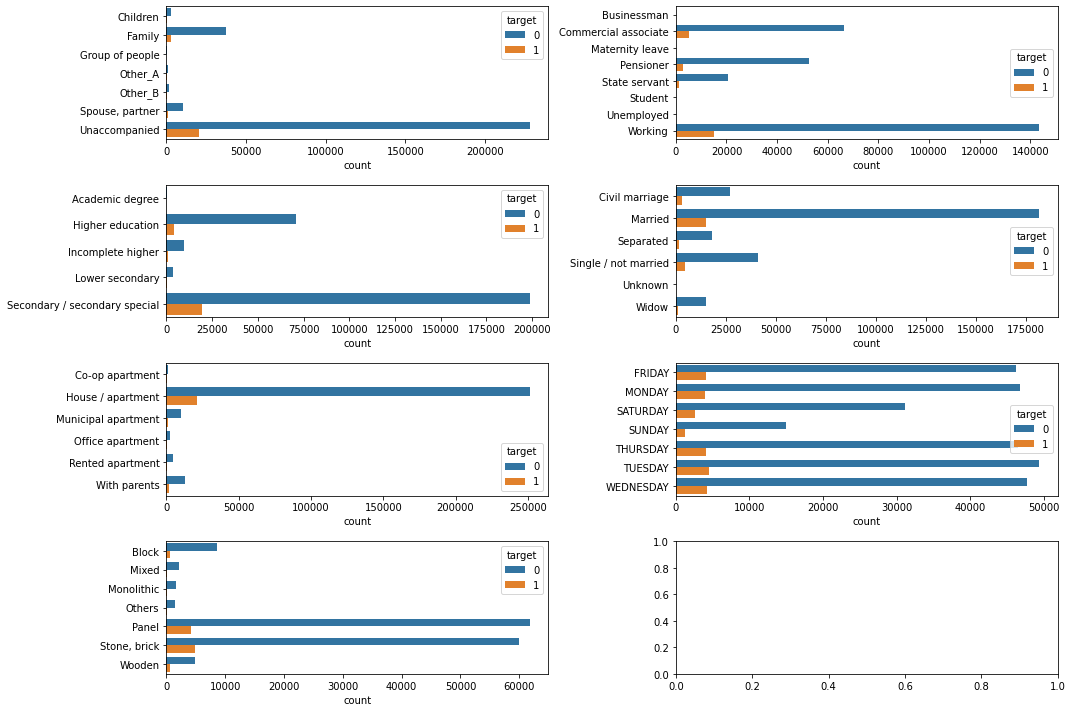

In [ ]:
#plot categorical Data (classification Task)
categorical = cat_col_5

fig, axes = plt.subplots(4, 2, figsize=(15, 10))
row = 0
cols = 0
for item in categorical:
    sns.countplot(y=item, hue="target", data=df, ax=axes[row][cols]).set_ylabel("")
    cols += 1
    if cols == 2:
        cols = 0
        row += 1
fig.tight_layout()

### Class Proportion 

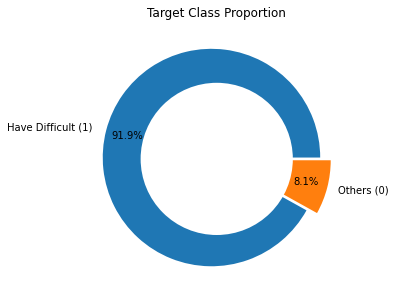

In [ ]:

plt.figure(figsize = (8,5)) 
names = ["Have Difficult (1) ","Others (0) "]
# Setting size in Chart based on 
# given values
target_perc = df.target.value_counts(normalize = True).to_list()
  
# colors
# explosion
explode = (0.05, 0.05)
  
# Pie Chart
plt.pie(target_perc, labels=names,
        autopct='%1.1f%%', pctdistance=0.80,
        explode=explode)
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title('Target Class Proportion')
# Displaying Chart
plt.show()

## Insight

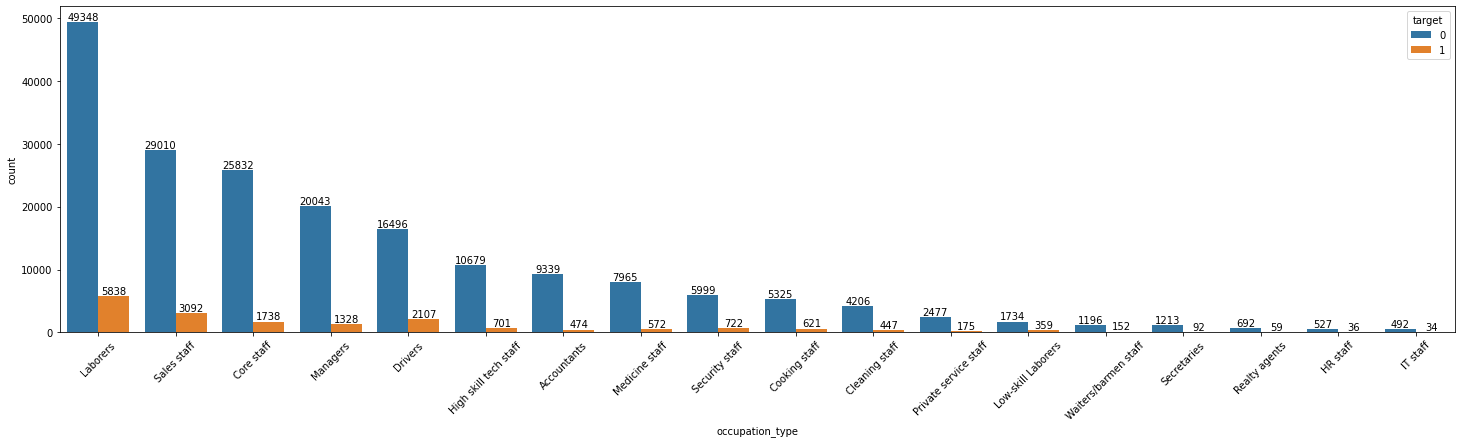

In [ ]:
plt.figure(figsize = (25,6))
plots = sns.countplot(x="occupation_type", hue="target", data=df,order = df["occupation_type"].value_counts().index)
plots.bar_label(plots.containers[0])
plots.bar_label(plots.containers[1] )
plt.xticks(rotation = 45);

<AxesSubplot:xlabel='occupation_type', ylabel='target'>

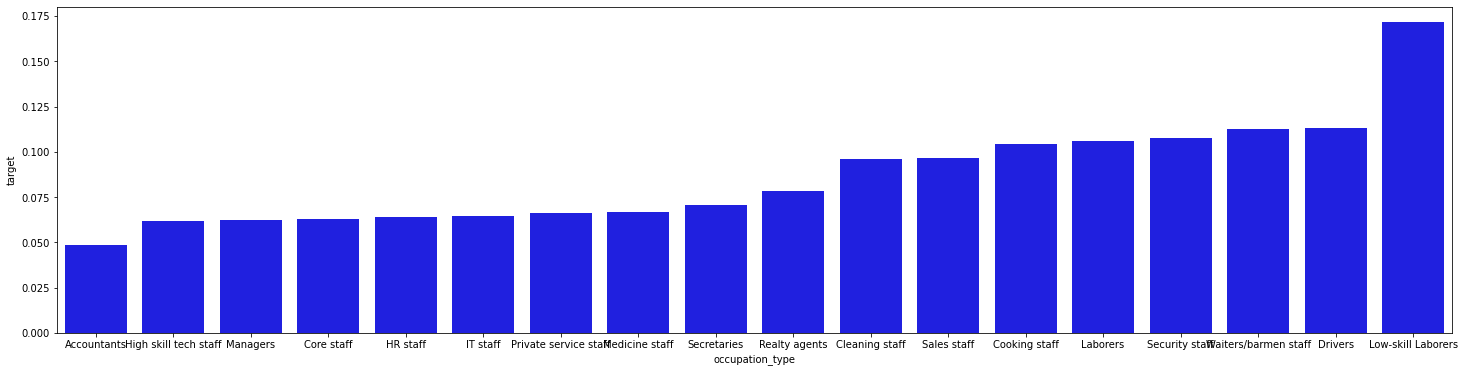

In [ ]:
occupation_perc = df.groupby("occupation_type")["target"].mean().sort_values().to_frame().reset_index()
plt.figure(figsize = (25,6))
sns.barplot(x = "occupation_type",y = "target",data = occupation_perc,order = occupation_perc["occupation_type"],color = "Blue")

In [11]:
test_df = df.loc[:,['reg_region_not_live_region','reg_region_not_work_region', 'live_region_not_work_region','reg_city_not_live_city', 'reg_city_not_work_city','live_city_not_work_city']].sum(axis = 1).to_frame("sum")

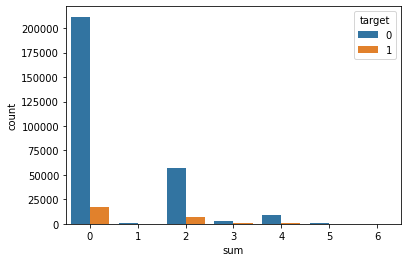

In [13]:
test_df["target"] = df.target
sns.countplot(x = "sum",hue = "target",data = test_df)

In [37]:
df.groupby("flag_own_realty")["target"].mean()

flag_own_realty
N    0.083249
Y    0.079616
Name: target, dtype: float64

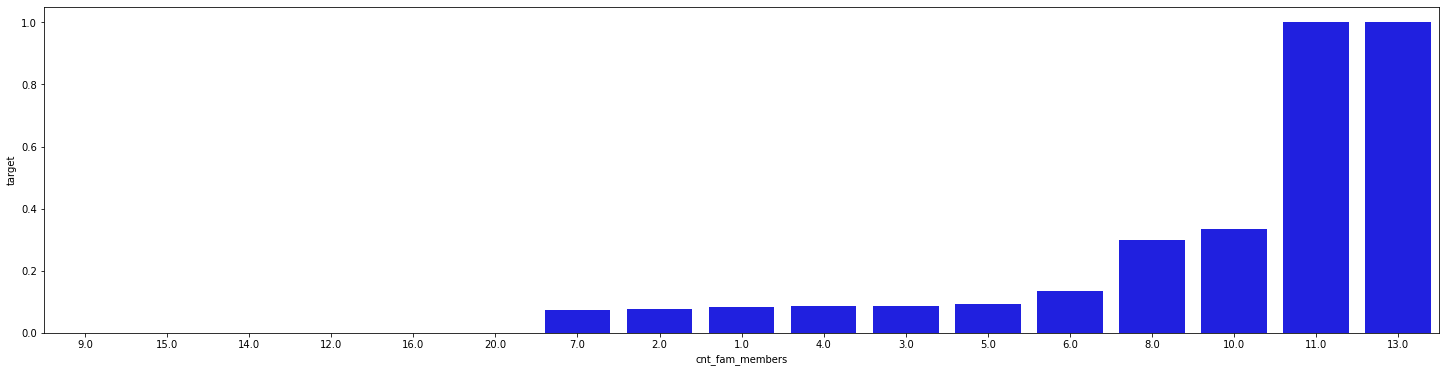

In [40]:
fam_member = df.groupby("cnt_fam_members")["target"].mean().sort_values().to_frame().reset_index()
plt.figure(figsize = (25,6))
sns.barplot(x = "cnt_fam_members",y = "target",data = fam_member,order = fam_member["cnt_fam_members"],color = "Blue")

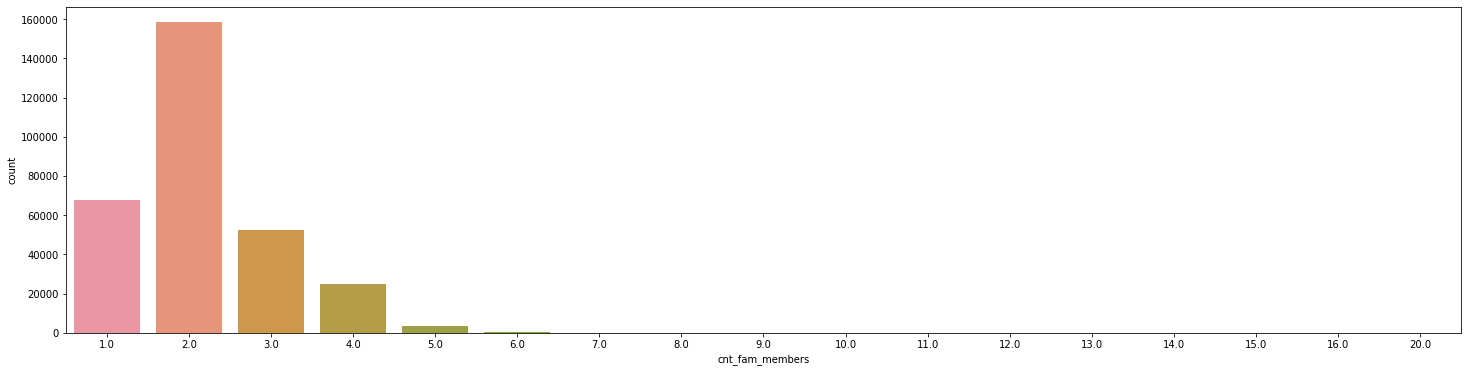

In [42]:
plt.figure(figsize = (25,6))
sns.countplot(x = "cnt_fam_members",data = df)

In [47]:
df[no_mis_col].to_csv("/content/drive/MyDrive/belajar python/case study/rakamin_home_credit/data/clean/app_train_72.csv")